# 2110443 - Computer Vision (2021/2)
## Lab 6 - Texture
In this lab, we will learn to use texture to segment 'things' from images. This notebook includes both coding and written questions. Please hand in this notebook file with all outputs and your answer. <br>
<b>Please note that collaboration is encouraged in this course.</b> You must turn in <b>your own write ups</b> of all problems. If you collaborate with others, you must put the names and ids of the students you worked with in below block.

<b>Remark : You need to install addition package name 'scikit-image' by using the following command line</b>

Collaboration List:
- ...
- ...

In [2]:
# !conda install scikit-image -c conda-forge -y

In [3]:
import numpy as np
import cv2
from skimage import io, color
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from matplotlib import pyplot as plt
from ipywidgets import interact,interactive
import ipywidgets as widgets
%matplotlib inline

## Gray Level Co-Occurrence Matrix (GLCM)
A gray level co-occurrence Matrix is a matrix that is defined over an image to be the distribution of co-occurring pixel values at a given offset. It is used as an approach to texture analysis with various computer vision applications.

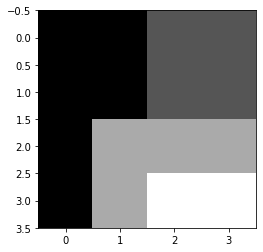

In [4]:
patternImage = np.array([
    [0, 0, 1, 1],
    [0, 0, 1, 1],
    [0, 2, 2, 2],
    [0, 2, 3, 3]], dtype=np.uint8)

plt.imshow(patternImage, cmap='gray')
plt.show()

We will use <a href="https://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=lbp#skimage.feature.greycomatrix">greycomatrix</a> function from scikit-image to extract GLCM from the sample pattern.

In [5]:
co_ocmatrix = graycomatrix(patternImage, distances=[1], angles=[0, np.pi/4, np.pi/2], levels=4)
print(co_ocmatrix.shape)
print('angle 0')
print(co_ocmatrix[:,:,0,0])

print('angle 45')
print(co_ocmatrix[:,:,0,1])

print('angle 90')
print(co_ocmatrix[:,:,0,2])

(4, 4, 1, 3)
angle 0
[[2 2 2 0]
 [0 2 0 0]
 [0 0 2 1]
 [0 0 0 1]]
angle 45
[[1 1 3 0]
 [0 1 1 0]
 [0 0 0 2]
 [0 0 0 0]]
angle 90
[[4 0 1 0]
 [0 2 2 0]
 [0 0 1 2]
 [0 0 0 0]]


### GLCM texture properties
Fron the  GLCM we can compute the following texture properties by using <a href='https://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=lbp#skimage.feature.graycoprops'>graycoprops</a> from scikit-image
- contrast $\sum_{i,j=0}^{levels-1} P_{i,j}(i-j)^2$
- dissimilarity $\sum_{i,j=0}^{levels-1}P_{i,j}|i-j|$
- homogeneity $\sum_{i,j=0}^{levels-1}\frac{P_{i,j}}{1+(i-j)^2}$
- correlation $\sum_{i,j=0}^{levels-1} P_{i,j}\left[\frac{(i-\mu_i)(j-\mu_j)}{\sqrt{(\sigma_i^2)(\sigma_j^2)}}\right]$

In [6]:
contrast = graycoprops(co_ocmatrix, prop='contrast')
dissimilarity = graycoprops(co_ocmatrix, prop='dissimilarity')
homogeneity = graycoprops(co_ocmatrix, prop='homogeneity')

print(contrast, dissimilarity,homogeneity)

[[0.91666667 1.77777778 0.66666667]] [[0.58333333 1.11111111 0.5       ]] [[0.74166667 0.51111111 0.76666667]]


In [7]:
patternImage2 = np.zeros((4,4), dtype=np.uint8) ## all black image!
co_ocmatrix2 = graycomatrix(patternImage2, distances=[1], angles=[0, np.pi/4, np.pi/2])

contrast2 = graycoprops(co_ocmatrix2, prop='contrast')
dissimilarity2 = graycoprops(co_ocmatrix2, prop='dissimilarity')
homogeneity2 = graycoprops(co_ocmatrix2, prop='homogeneity')

print(contrast2, dissimilarity2, homogeneity2)

[[0. 0. 0.]] [[0. 0. 0.]] [[1. 1. 1.]]


### Co-Occurrence matrix patch matching on bridge defect problem

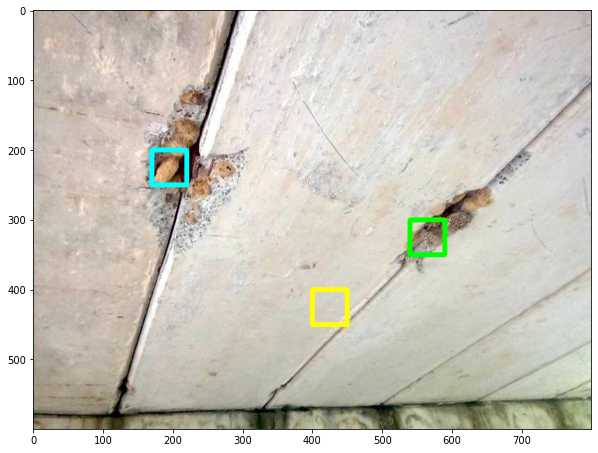

In [8]:
bridgeDefectImage = cv2.imread('assets/Lab6-crack.jpg')
dispImage = cv2.cvtColor(bridgeDefectImage.copy(), cv2.COLOR_BGR2RGB)

# Sample crack
cv2.rectangle(dispImage, (170,200), (220,250), (0,255,255), 5)

# Normal1
cv2.rectangle(dispImage, (400,400), (450,450), (255,255,0), 5)

# Crack2
cv2.rectangle(dispImage, (540,300), (590,350), (0,255,0), 5)


plt.figure(figsize=(10,10))
plt.imshow(dispImage, cmap='gray')

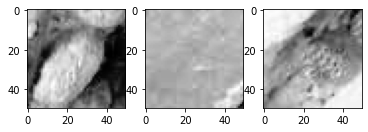

In [9]:
bridgeDefectImageGray = cv2.cvtColor(bridgeDefectImage, cv2.COLOR_BGR2GRAY)

crackPatch1 = bridgeDefectImageGray[200:250,170:220]

normalPatch1= bridgeDefectImageGray[400:450,400:450]

crackPatch2 = bridgeDefectImageGray[300:350,540:590]

_, axarr = plt.subplots(1,3)
axarr[0].imshow(crackPatch1, cmap='gray')
axarr[1].imshow(normalPatch1, cmap='gray')
axarr[2].imshow(crackPatch2, cmap='gray')

In [10]:
co_ocmatrix_crackpatch1 = graycomatrix(crackPatch1, distances=[1], angles=[0, np.pi/4, np.pi/2], symmetric=True, normed=True)

co_ocmatrix_normalpatch1 = graycomatrix(normalPatch1, distances=[1], angles=[0, np.pi/4, np.pi/2], symmetric=True, normed=True)

co_ocmatrix_crackpatch2 = graycomatrix(crackPatch2, distances=[1], angles=[0, np.pi/4, np.pi/2], symmetric=True, normed=True)

In [11]:
dist_normal_normal = np.linalg.norm(co_ocmatrix_crackpatch1-co_ocmatrix_crackpatch2)
print('distance crack-crack', dist_normal_normal)

dist_normal_crack = np.linalg.norm(co_ocmatrix_crackpatch1-co_ocmatrix_normalpatch1)
print('distance normal-crack', dist_normal_crack)

distance crack-crack 0.04674394760128204
distance normal-crack 0.1884948283571507


## Local Binary Pattern (LBP)
Local Binary Pattern (LBP) is a efficient texture operator which labels the pixels of an image by thresholding the neighborhood of each pixel and considers the result as a binary number.  It can be seen as a unifying approach to the traditionally divergent statistical and structural models of texture analysis. The most important property of the LBP operator in real-world applications is its robustness to monotonic gray-scale changes caused, for example, by illumination variations. Another important property is its computational simplicity, which makes it possible to analyze images in challenging real-time settings.

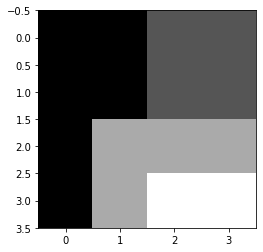

In [12]:
patternImage = np.array([
    [0, 0, 1, 1],
    [0, 0, 1, 1],
    [0, 2, 2, 2],
    [0, 2, 3, 3]], dtype=np.uint8)

plt.imshow(patternImage, cmap='gray')
plt.show()

In [13]:
lbpfeature = local_binary_pattern(patternImage, 8, 1)

Calculate LBP pattern for each patch by using scikit-image <a href="https://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=lbp#skimage.feature.local_binary_pattern">local_binary_pattern</a> <br>
<img src="assets/Lab6-LBP.jpg"/><br> Three neighborhood examples with varying p and r used to construct Local Binary Patterns. (Image from <a href="https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/">pyimagesearch</a>)

[[255. 255. 193. 112.]
 [255. 255. 231. 124.]
 [255. 193. 241. 112.]
 [255.   7.   1.  16.]]


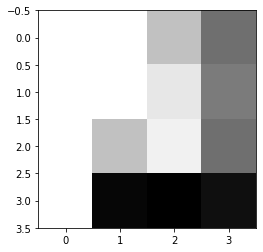

In [14]:
plt.imshow(lbpfeature, cmap='gray')
print(lbpfeature)

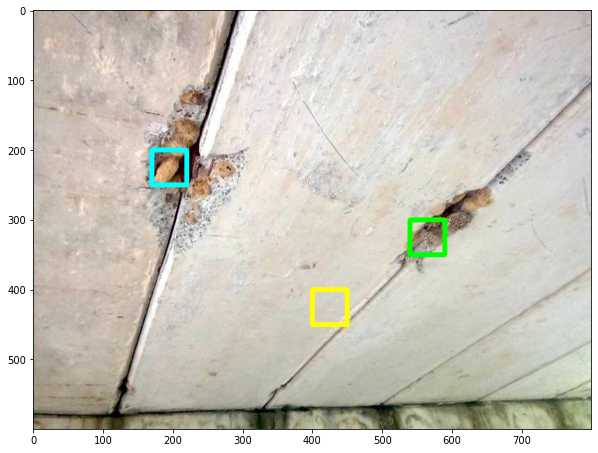

In [15]:
bridgeDefectImage = cv2.imread('assets/Lab6-crack.jpg')
dispImage = cv2.cvtColor(bridgeDefectImage.copy(), cv2.COLOR_BGR2RGB)

# Sample crack
cv2.rectangle(dispImage, (170,200), (220,250), (0,255,255), 5)

# Normal1
cv2.rectangle(dispImage, (400,400), (450,450), (255,255,0), 5)

# Crack2
cv2.rectangle(dispImage, (540,300), (590,350), (0,255,0), 5)


plt.figure(figsize=(10,10))
plt.imshow(dispImage, cmap='gray')

In [16]:
lbp_crackpatch1 =  local_binary_pattern(crackPatch1, P=16, R=8, method='uniform') 
lbp_normalpatch1 =  local_binary_pattern(normalPatch1, P=16, R=8, method='uniform')
lbp_crackpatch2 =  local_binary_pattern(crackPatch2, P=16, R=8, method='uniform') 

### LBP histogram

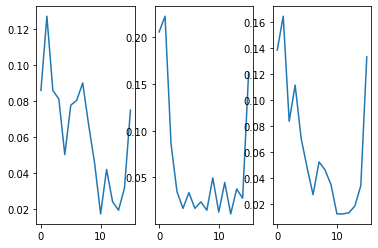

In [17]:
nBin = 16

_, axarr = plt.subplots(1,3)

hist_crackpatch1, _ = np.histogram(lbp_crackpatch1, density=True, bins=nBin, range=(0, nBin))
axarr[0].plot(hist_crackpatch1)

hist_normalpatch1, _ = np.histogram(lbp_normalpatch1, density=True, bins=nBin, range=(0, nBin))
axarr[1].plot(hist_normalpatch1)
    
hist_crackpatch2, _ = np.histogram(lbp_crackpatch2, density=True, bins=nBin, range=(0, nBin))
axarr[2].plot(hist_crackpatch2)

plt.show()

### LBP Histogram matching

#### Simple euclidean distance

In [18]:
print('Eucliden distance between crack-crack',np.linalg.norm(hist_crackpatch1 - hist_crackpatch2))
print('Eucliden distance between crack-normal',np.linalg.norm(hist_crackpatch1 - hist_normalpatch1))

Eucliden distance between crack-crack 0.1250927629301786
Eucliden distance between crack-normal 0.21904259947293234


#### KL divergence is a way of measuring the matching between two distributions 
(More detail can  be read from <a href="https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-understanding-kl-divergence-2b382ca2b2a8">here</a>)

In [19]:
def kldivergence(p, q):
    filt = np.logical_and(p != 0, q != 0)
    return np.sum(p[filt] * np.log2(p[filt] / q[filt]))

print('KL-Divergence between crack-crack', kldivergence(hist_crackpatch1 , hist_crackpatch2))
print('KL-Divergence between crack-normal', kldivergence(hist_crackpatch1 , hist_normalpatch1))

KL-Divergence between crack-crack 0.18014212991374018
KL-Divergence between crack-normal 0.49131425627283865


## Morphological Transformations

The field of mathematical morphology contributes a wide range of operators to image processing, all based around a simple mathematical concepts from set theory. Morphological transformations are the operations based on the image shapeimport numpy as np
import cv2
from skimage import io, color
from skimage.feature import local_binary_pattern, greycomatrix, greycoprops
from matplotlib import pyplot as plt employed on binay images. This operation needs needs two inputs, one is binary image, second one is called <b>structuring element or kernel</b> which decides the operation output. You can design the kernel to suit your application needs. Two basic morphological operators are Erosion and Dilation

The following mask image is segmented by using color information. You can see that there are some hand's pixels which are not connect into a perfect hand shape. We can correct these by using the basic morphological operaters.

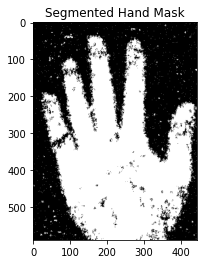

In [20]:
handMask = cv2.imread('assets/Lab5-SegmentedHand.png',cv2.IMREAD_GRAYSCALE)
plt.title('Segmented Hand Mask')
plt.imshow(handMask,cmap='gray')
plt.show()

In [21]:
def openAndCloseMorph(kernelSize,kernelShape, morphType):
    kernel = cv2.getStructuringElement(kernelShape,(kernelSize,kernelSize))
    
    outputImage = handMask.copy()
    
    if morphType == 'erode':
        outputImage = cv2.erode(outputImage,kernel,iterations = 1)
    else:
        outputImage = cv2.dilate(outputImage,kernel,iterations = 1)

    plt.figure(figsize=(5,5))
    plt.imshow(outputImage, cmap='gray')
    plt.show()
    
    print('Morphology Kernel Shape:')
    display(kernel)
    
interact(openAndCloseMorph, kernelSize=widgets.IntSlider(min=1,max=11,step=1,value=1), 
         kernelShape=widgets.Dropdown(
                        options=[cv2.MORPH_RECT,cv2.MORPH_ELLIPSE, cv2.MORPH_CROSS],
                        value=cv2.MORPH_RECT,
                        description='kernelShape:',
                        disabled=False),
        morphType=widgets.Dropdown(
                        options=['erode','dilate'],
                        value='erode',
                        description='Morph Type:',
                        disabled=False)
);

interactive(children=(IntSlider(value=1, description='kernelSize', max=11, min=1), Dropdown(description='kerne…

This <a href="https://docs.opencv.org/3.4.2/d9/d61/tutorial_py_morphological_ops.html">page</a> shows a good morphological operation exmple, try to write an interactive visualization like the above sample on <b>Opening and Closing</b> operations. See the output results by yourself.

In [22]:
### FILL HERE ###
def openAndCloseMorph(kernelSize,kernelShape, morphType):
    kernel = cv2.getStructuringElement(kernelShape,(kernelSize,kernelSize))
    
    outputImage = handMask.copy()
    
    if morphType == 'close':
        outputImage = cv2.dilate(outputImage,kernel,iterations = 1)
        outputImage = cv2.erode(outputImage,kernel,iterations = 1)
    else:
        outputImage = cv2.erode(outputImage,kernel,iterations = 1)
        outputImage = cv2.dilate(outputImage,kernel,iterations = 1)

    plt.figure(figsize=(5,5))
    plt.imshow(outputImage, cmap='gray')
    plt.show()
    
    print('Morphology Kernel Shape:')
    display(kernel)
    
interact(openAndCloseMorph, kernelSize=widgets.IntSlider(min=1,max=11,step=1,value=1), 
         kernelShape=widgets.Dropdown(
                        options=[cv2.MORPH_RECT,cv2.MORPH_ELLIPSE, cv2.MORPH_CROSS],
                        value=cv2.MORPH_RECT,
                        description='kernelShape:',
                        disabled=False),
        morphType=widgets.Dropdown(
                        options=['open','close'],
                        value='open',
                        description='Morph Type:',
                        disabled=False)
);
#################

interactive(children=(IntSlider(value=1, description='kernelSize', max=11, min=1), Dropdown(description='kerne…

## Assignment 1 - Texture Segmentation

From the above section, we can magically matching each texture with sample patches. Your today task is to implement a program to segment this leopard from the background by using chosen texture feature and sliding window method. You can search and use any knowledge from internet but do not forget to proper credit your sources. <br>
<img src="assets/Lab6-leopard.jpg"/>

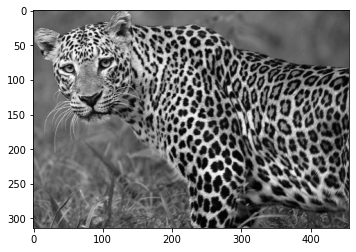

<Figure size 432x288 with 0 Axes>

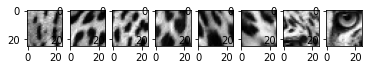

<Figure size 432x288 with 0 Axes>

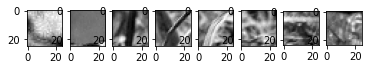

In [23]:
leopardImage = cv2.imread('assets/Lab6-leopard.jpg', cv2.IMREAD_GRAYSCALE)
leopardImage = cv2.resize(leopardImage, None,fx=0.5,fy=0.5) #resize to reduce computation time

# 8 patches which have size of 25*25 
leopardPatches = [leopardImage[100:125, 150:175],
                  leopardImage[100:125, 400:425],
                  leopardImage[130:155, 180:205],
                  leopardImage[130:155, 430:455],
                  leopardImage[200:225, 300:325],
                  leopardImage[230:255, 330:355],
                  leopardImage[50:75, 100:125],
                  leopardImage[70:95, 90:115],
                  ]

# 8 patches which have size of 25*25 
nonleopardPatches = [leopardImage[0:25, 300:325],
                     leopardImage[0:25, 200:225],
                     leopardImage[250:275, 100:125],
                     leopardImage[275:300, 25:50],
                     leopardImage[275:300, 75:100],
                     leopardImage[275:300, 150:175],
                     leopardImage[290:315, 340:365],
                     leopardImage[290:315, 400:425],
                     ]

plt.figure()
plt.imshow(leopardImage, cmap='gray')

plt.figure()
_, axarr = plt.subplots(1,len(leopardPatches))
for enum,leopardPatch in enumerate(leopardPatches):
    axarr[enum].imshow(leopardPatch, cmap='gray')

plt.figure()
_, axarr = plt.subplots(1,len(nonleopardPatches))
for enum,nonleopardPatch in enumerate(nonleopardPatches):
    axarr[enum].imshow(nonleopardPatch, cmap='gray')

In [24]:
# Find Gray Level Co-Occurrence Matrix (GLCM) of each patches
co_leopardPatches = [graycomatrix(leopardPatch, distances=[1], angles=[0, np.pi/4, np.pi/2], symmetric=True, normed=True) for leopardPatch in leopardPatches]
co_nonleopardPatches = [graycomatrix(nonleopardPatch, distances=[1], angles=[0, np.pi/4, np.pi/2], symmetric=True, normed=True) for nonleopardPatch in nonleopardPatches]

In [25]:
# Sliding window by window size and stride 
def sliding_window(image, window_size, stride):
    for y in range(0, image.shape[0], stride):
        for x in range(0, image.shape[1], stride):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

# Matching texture of each window using KNN algorithm (k=3)
def processTexture(image):
    co =  graycomatrix(image, distances=[1], angles=[0, np.pi/4, np.pi/2], symmetric=True, normed=True) 
    argsort = np.argsort([np.linalg.norm(i-co) for i in co_leopardPatches+co_nonleopardPatches])
    k=3
    return np.sum(argsort[:k]<len(co_leopardPatches)) > k//2

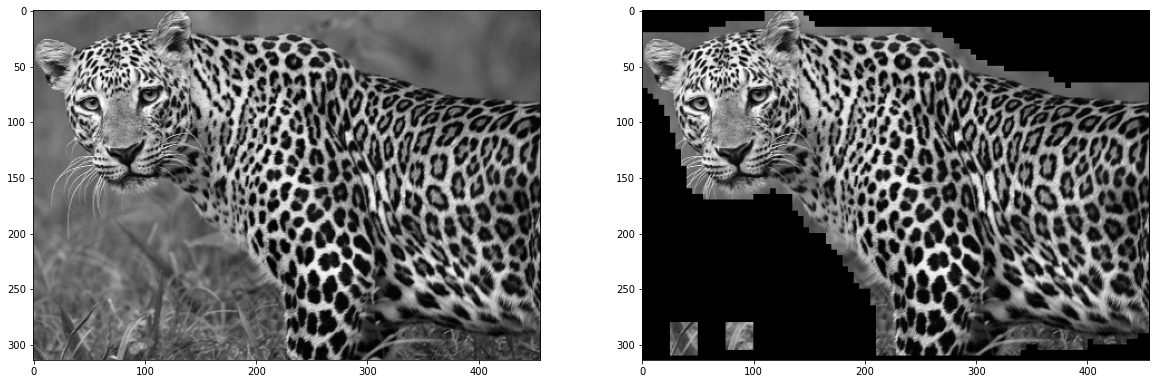

In [26]:
# Calculate mask 
window_size = (25, 25)
stride = 5
mask = np.zeros_like(leopardImage)

for (x, y, window) in sliding_window(leopardImage, window_size, stride):
    if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
        continue
    if processTexture(window):
        mask[y:y + window_size[1], x:x + window_size[0]] = np.ones_like(window)*255

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(leopardImage, cmap="gray")
plt.subplot(1,2,2)
plt.imshow(mask & leopardImage, cmap="gray")

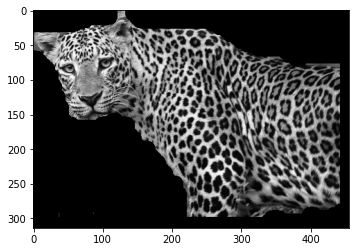

In [27]:
# Morphological operation
kernel = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(25,25))
mask2 = cv2.morphologyEx(mask, op=cv2.MORPH_ERODE, kernel=kernel)
plt.imshow(mask2 & leopardImage, cmap="gray")